In [84]:
import repackage
repackage.up()

from datasets.nuscenes import NuScenesMultipleRadarMultiSweeps
from utils.occupancy import *
from utils.labelling import *
from utils.transforms import *
from utils.postprocessing import *
from utils.ransac_solver import RANSACSolver
from utils.motion_estimation import *
from autolabeler import AutoLabeler
import pandas as pd
import os.path as osp
import numpy as np
import open3d as o3d
from pathlib import Path
from nuscenes import NuScenes
from multiprocessing import cpu_count, Pool, set_start_method
import matplotlib
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import RadarPointCloud
RadarPointCloud.default_filters()

## Full Pipeline

Testing on a single row of the matched scenes dataframe

In [ ]:
DATA_DIR = "/shared/data/nuScenes/"
versions = {'trainval': 'v1.0-trainval', 'test': 'v1.0-test'}
nuscenes_exp = {
    vname: NuScenes(dataroot=DATA_DIR, version=version, verbose=False)
    for vname, version in versions.items()
}

In [98]:
ref_frame = None
NUM_SWEEPS = 5
ref_sensor = 'RADAR_FRONT'
filter_points = False

DPR_THRESH = 0.15
VOXEL_SIZE = 0.01

DF_PATH = '../sps_nuscenes_more_matches_df.json'
sps_df = pd.read_json(DF_PATH)


ICP_FILTERING = True
SEARCH_IN_RADIUS = True
RADIUS = 1
USE_LIDAR_LABELS = False
USE_OCCUPANCY_PRIORS = True
FILTER_BY_POSES = False
FILTER_BY_RADIUS = False
FILTER_OUT_OF_BOUNDS = False
USE_COMBINED_MAP = False


SENSORS = ["RADAR_FRONT", "RADAR_FRONT_LEFT", "RADAR_FRONT_RIGHT", "RADAR_BACK_LEFT", "RADAR_BACK_RIGHT"]

In [99]:
sps_df.head()

,scene_name,first_frame_datetime,days_since_first_recording,hours_since_first_recording,month,split,closest_scenes,closest_scenes_data
121,scene-0161,1526922443042,0,0.000000,May,trainval,[scene-0218],{'scene-0218': {'scene_token': 'febc1800b9ed43...
122,scene-0162,1526922463034,0,0.005553,May,trainval,"[scene-0665, scene-0218, scene-0219]",{'scene-0665': {'scene_token': '45275e709d4a4b...
123,scene-0163,1526922483050,0,0.011113,May,trainval,"[scene-0075, scene-0511, scene-0332, scene-045...",{'scene-0075': {'scene_token': '01c3f5e3995640...
124,scene-0164,1526922518041,0,0.020833,May,trainval,"[scene-0513, scene-0091]",{'scene-0513': {'scene_token': 'e333874a12d64a...
125,scene-0165,1526922555077,0,0.031121,May,trainval,"[scene-0092, scene-0333, scene-0265, scene-0062]",{'scene-0092': {'scene_token': '7365495b744646...


In [101]:
row = sps_df.iloc[0]

In [102]:
ref_scene_name = row['scene_name']
ref_split = row['split']
closest_scenes = row['closest_scenes_data']

In [103]:
## Create Dataloader for each scene in a record
dataloaders = {ref_scene_name : NuScenesMultipleRadarMultiSweeps(
    data_dir=DATA_DIR,
    nusc=nuscenes_exp[ref_split],
    sequence=int(ref_scene_name.split("-")[-1]),
    sensors=SENSORS,
    nsweeps=NUM_SWEEPS,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=filter_points,
    ransac_threshold=DPR_THRESH,
    reformat_pcl=False

)}

for matched_scene, data in closest_scenes.items():
    dataloaders[matched_scene] = NuScenesMultipleRadarMultiSweeps(
    data_dir=DATA_DIR,
    nusc=nuscenes_exp[data['split']],
    sequence=int(matched_scene.split("-")[-1]),
    sensors=SENSORS,
    nsweeps=NUM_SWEEPS,
    ref_frame=ref_frame,
    ref_sensor=ref_sensor,
    apply_dpr=False,
    filter_points=filter_points,
    ransac_threshold=DPR_THRESH,
    reformat_pcl=False
)

dataloaders.keys()

dict_keys(['scene-0161', 'scene-0218'])

In [104]:
scene_pointclouds = {name : [dl[i][0] for i in range(dl.num_readings)] for name,dl in dataloaders.items()}
scene_calibs = {name : [dl[i][1] for i in range(dl.num_readings)] for name,dl in dataloaders.items()}
scene_poses = {name: dl.global_poses for name,dl in dataloaders.items()}

In [105]:
def remove_dynamic_points(scene_pointclouds, scene_calibs, scene_poses, dpr_thresh=0.15, save_vis=False):
    ransac_solver = RANSACSolver(threshold=dpr_thresh, max_iter=10, outdir='output_dpr')

    dpr_masks = {scene_name: [] for scene_name in scene_pointclouds}
    global_scene_pointclouds = {scene_name: [] for scene_name in scene_pointclouds}


    for scene_name in scene_pointclouds:
        scans_pcl = scene_pointclouds[scene_name]
        scans_calibs = scene_calibs[scene_name]
        poses = scene_poses[scene_name]
        
        for index, (sensor_pcls, sensor_calibs, pose) in enumerate(zip(scans_pcl, scans_calibs, poses)):
            merged_pcl_global = []
            merged_pcl_dpr_mask = []

            for sensor, pcl, calib in zip(SENSORS, sensor_pcls, sensor_calibs):
                if pcl.shape[0] > 1:
                    info = [
                        [scene_name, index],
                        sensor,
                        pcl.shape[0]
                    ]
                    best_mask, _, _ = ransac_solver.ransac_nusc(pcl, vis=save_vis, info=info)

                    ego_points_sensor = transform_doppler_points(calib, pcl)
                    global_points_sensor = transform_doppler_points(pose, ego_points_sensor)
                    merged_pcl_global.append(global_points_sensor)
                    merged_pcl_dpr_mask.append(best_mask)
            
            dpr_masks[scene_name].append(np.hstack(merged_pcl_dpr_mask))
            global_scene_pointclouds[scene_name].append(np.vstack(merged_pcl_global))

    return dpr_masks, global_scene_pointclouds

In [106]:
## Using Dani's Motion Estimation
def process_point_clouds(point_clouds_dict, calib_dict, poses_dict, use_ransac=True, threshold=0.5):
    inliers_dict = {name: [] for name in point_clouds_dict}
    scene_pointclouds = {name: [] for name in point_clouds_dict}

    for scene_name in point_clouds_dict:
        scans_pcls = point_clouds_dict[scene_name]
        scans_calibs = calib_dict[scene_name]
        scans_poses = poses_dict[scene_name]
        inliers_dict[scene_name] = []


        for sensor_pcls, sensor_calibs, pose in zip(scans_pcls, scans_calibs, scans_poses):
            # Aggregate point clouds to sensor frame
            aggregated_points = aggregate_to_sensor_frame(sensor_pcls)

            # Estimate velocity using RANSAC
            velocity_estimate = estimate_velocity_from_multiple_sensors(aggregated_points, sensor_calibs, use_ransac, threshold)
            estimated_w, estimated_v = velocity_estimate
            
            # Get inliers based on estimated velocity
            inliers = get_inliers_from_known_velocity(aggregated_points, sensor_calibs, estimated_w, estimated_v, threshold)
            inliers_dict[scene_name].append(inliers)

            merged_pcls = []
            for pcl, calib in zip(sensor_pcls, sensor_calibs):
                ego_pcl = transform_doppler_points(calib, pcl)
                global_pcl = transform_doppler_points(pose, ego_pcl)
                merged_pcls.append(global_pcl)
            scene_pointclouds[scene_name].append(np.vstack(merged_pcls))

    
    return inliers_dict, scene_pointclouds

In [107]:
# inliers_dict, global_scene_pointclouds = process_point_clouds(scene_pointclouds, scene_calibs, scene_poses, use_ransac=True, threshold=1)
# scene_maps = {name : np.vstack(pcls) for name,pcls in global_scene_pointclouds.items()}
# scene_dpr_masks = {name : np.hstack(masks) for name,masks in inliers_dict.items()}

In [108]:
scene_pointclouds_dpr_masks, scene_pointclouds = remove_dynamic_points(scene_pointclouds, scene_calibs, scene_poses, dpr_thresh=0.15, save_vis=False)

In [109]:
scene_dpr_masks = {name : np.hstack(masks) for name,masks in scene_pointclouds_dpr_masks.items()}
scene_maps = {name : np.vstack(pcls) for name,pcls in scene_pointclouds.items()}

In [110]:
def plot_dpr_masks(scene, map_pcl, mask):
    plt.figure(figsize=(10, 10))
    
    plt.scatter(map_pcl[:, 0], map_pcl[:, 1], s=0.25, label='static', c='green', alpha=0.5)
    dpr_map = map_pcl[:len(mask)]
    dpr_map = dpr_map[~mask]
    plt.scatter(dpr_map[:, 0], dpr_map[:, 1], s=0.25, label='dynamic', c='red', alpha=0.5)
    plt.title(scene)
    plt.xlabel('X')
    plt.ylabel('Y')

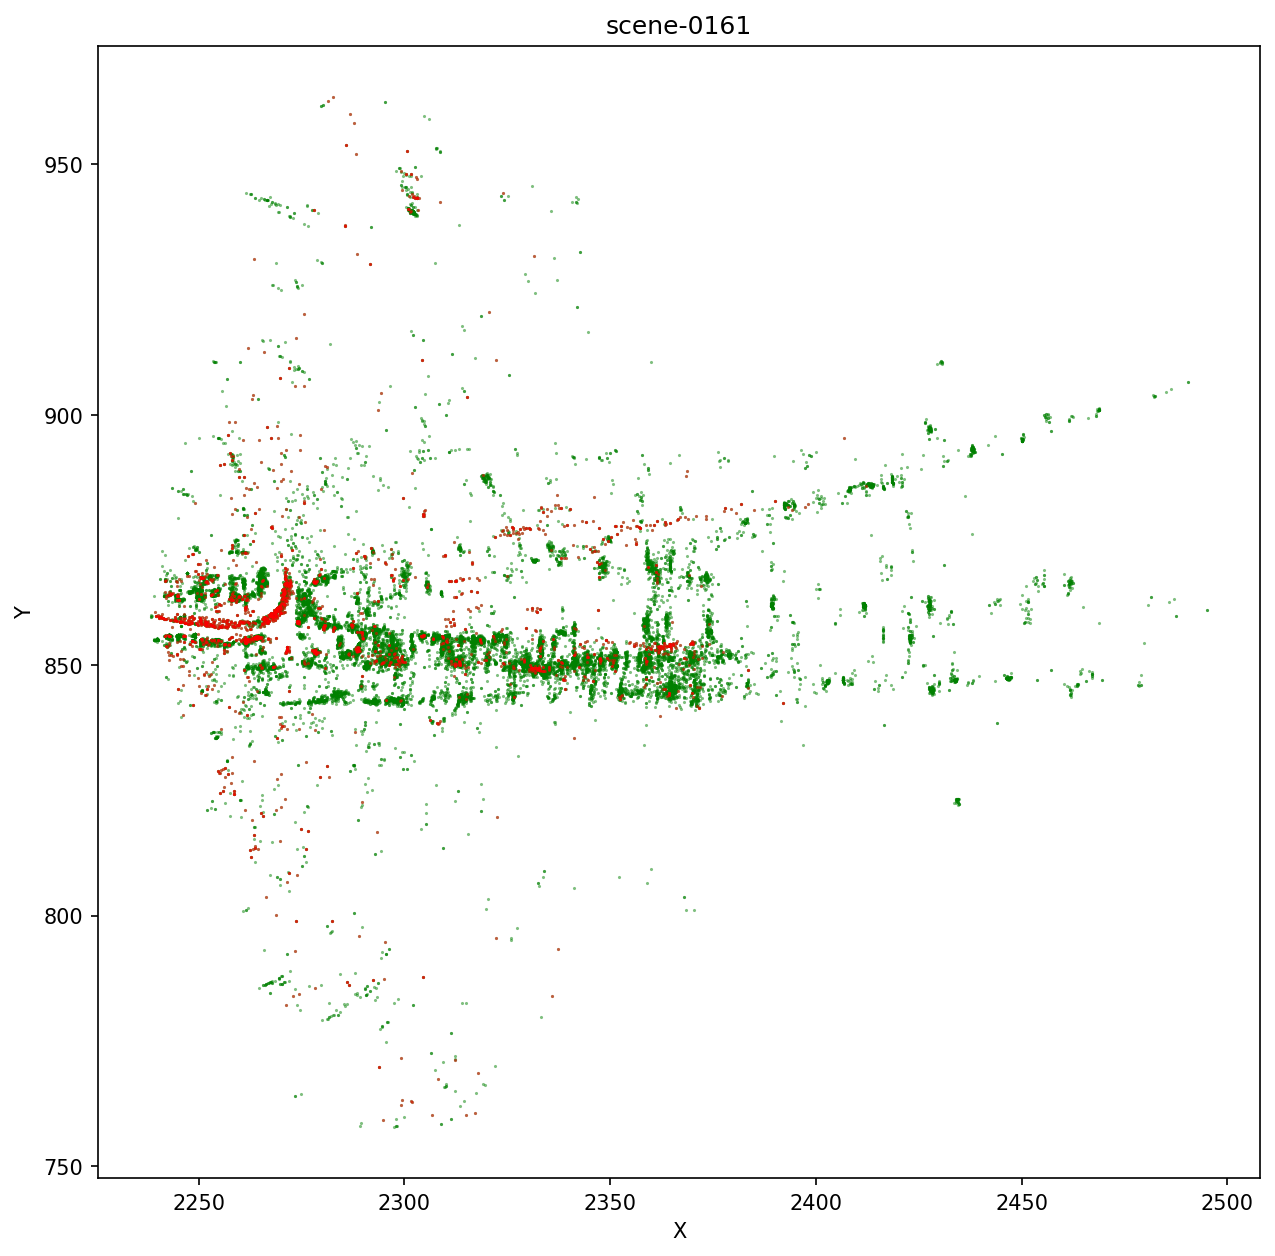

In [111]:
scene_name = ref_scene_name
plot_dpr_masks(scene_name, scene_maps[scene_name], scene_dpr_masks[scene_name])

In [112]:
dpr_scene_maps = {}
for name in scene_maps:
    indices = scene_dpr_masks[name]
    map_pcl = scene_maps[name]
    filtered_map_pcl = map_pcl[indices]
    print(name, len(map_pcl), len(filtered_map_pcl))
    dpr_scene_maps[name] = filtered_map_pcl

scene-0161 28623 26335
scene-0218 27456 27179


In [113]:
np.unique(indices, return_counts=True)

(array([False,  True]), array([  277, 27179]))

In [114]:
import matplotlib.pyplot as plt
import numpy as np

def plot_maps(scene_maps, poses, size=0.5, zoom_level=3):
    plt.figure(figsize=(10, 10))

    colors = ['cyan', 'magenta', 'yellow', 'black', 'purple', 'brown']
    markers = ['o', 'v', 's', 'P', 'X', 'D']
    positions = {name: np.array(pose)[:, :3,3] for name,pose in poses.items()}

    for idx, (scene_name, map) in enumerate(scene_maps.items()):

        plt.scatter(map[:, 0], map[:, 1], s=size, label=scene_name, alpha=0.5)


        if scene_name in positions:
            pose = np.array(positions[scene_name])
            plt.plot(pose[:, 0], pose[:, 1], label=f'{scene_name} Trajectory', color=colors[idx % len(colors)])
            # plt.scatter(pose[:, 0], pose[:, 1], c=colors[idx % len(colors)], marker=markers[idx % len(markers)])
            
            for i in range(1, len(pose)):
                plt.arrow(pose[i-1, 0], pose[i-1, 1], pose[i, 0] - pose[i-1, 0], pose[i, 1] - pose[i-1, 1], 
                          head_width=0.5, head_length=0.5, fc=colors[idx % len(colors)], ec=colors[idx % len(colors)])

    plt.xlabel('X')
    plt.ylabel('Y')

    if zoom_level != -1:
        all_pos = np.concatenate(list(positions.values()))
        x_mean = np.mean(all_pos[:,0])
        y_mean = np.mean(all_pos[:,1])
        x_std = np.std(all_pos[:,0])
        y_std = np.std(all_pos[:,1])
        
        std_dev_range = zoom_level

        x_limits = [x_mean - std_dev_range*x_std, x_mean + std_dev_range*x_std]
        y_limits = [y_mean - std_dev_range*y_std, y_mean + std_dev_range*y_std]

        plt.xlim(x_limits)
        plt.ylim(y_limits)

    plt.title("Overlapped Maps and Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()

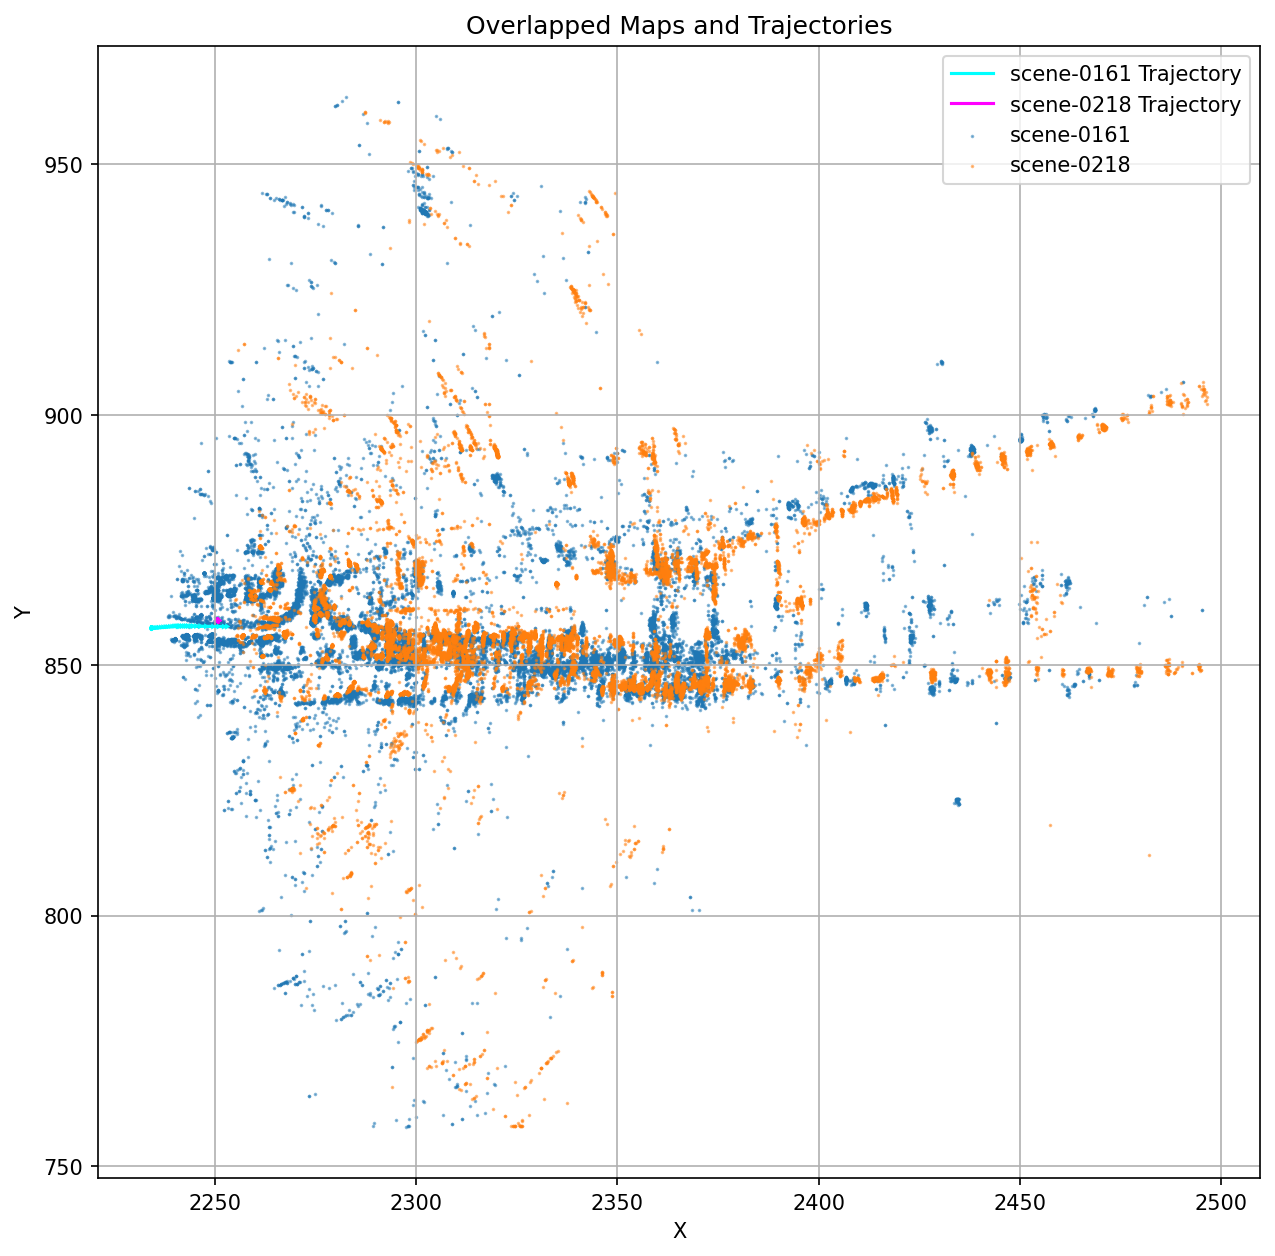

In [115]:
plot_maps(scene_maps=scene_maps, poses=scene_poses, zoom_level=-1)

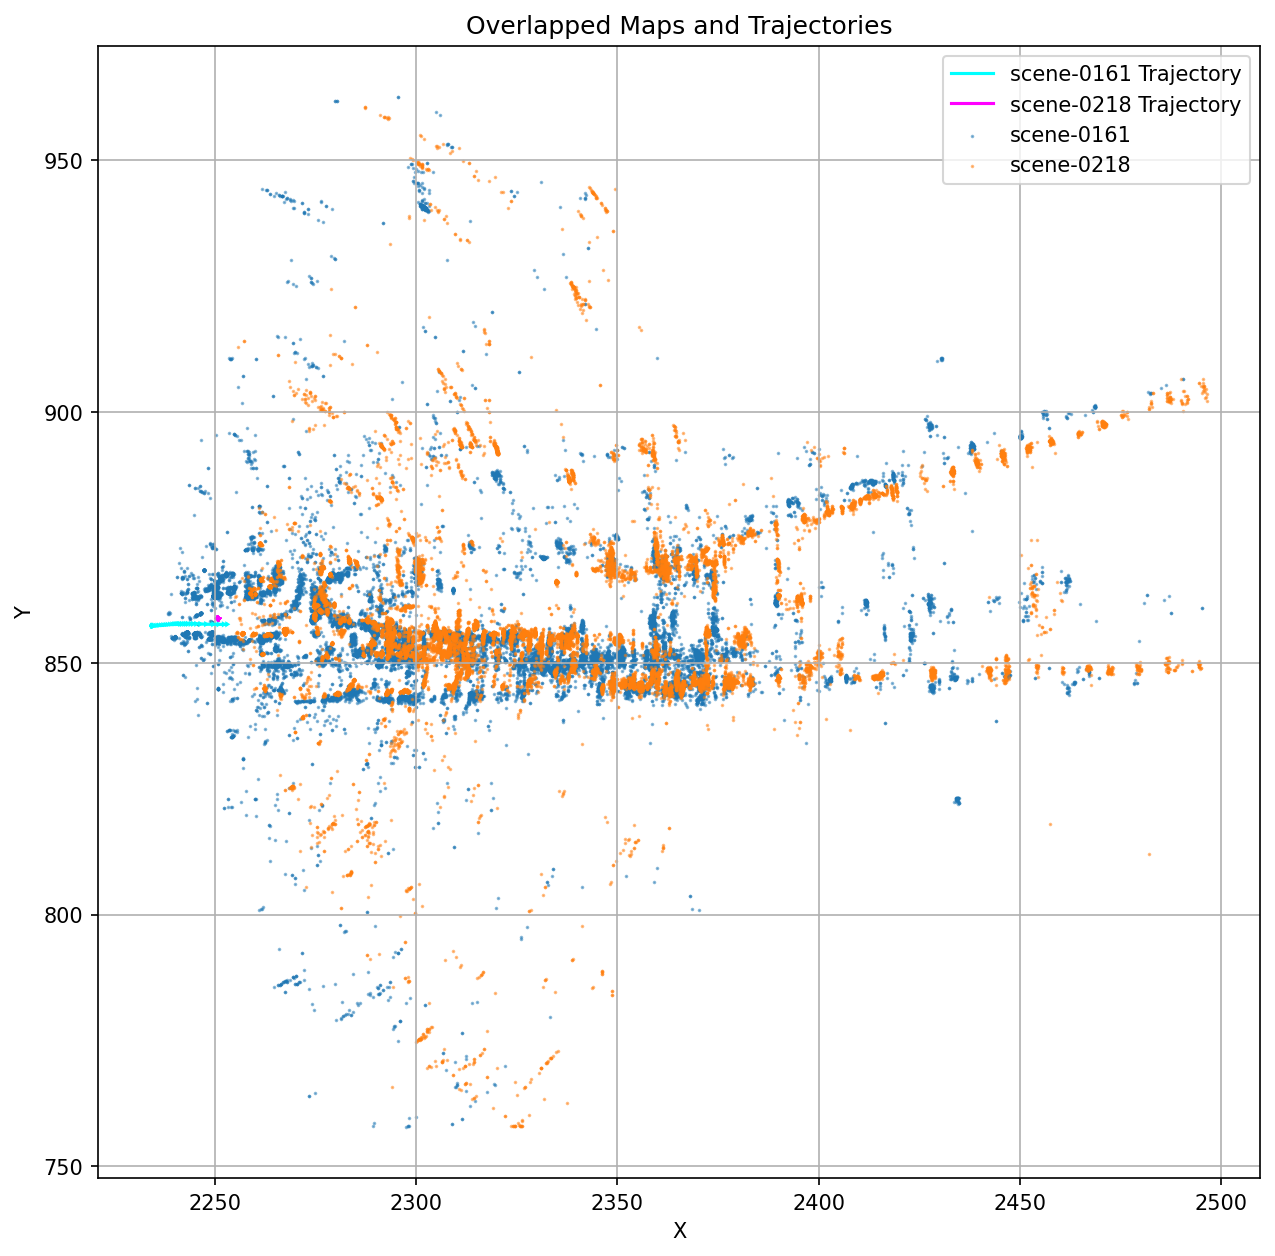

In [116]:
plot_maps(scene_maps=dpr_scene_maps, poses=scene_poses, zoom_level=-1)

In [ ]:
# filtered_scene_maps, filtered_scene_poses = create_filtered_maps(scene_poses, scene_pointclouds, threshold=1)

In [ ]:
# plot_maps(filtered_scene_maps, filtered_scene_poses, zoom_level=7)

In [ ]:
# filtered_radius_scene_maps, filtered_radius_scene_poses = create_filtered_maps_with_radius(scene_poses, scene_pointclouds, threshold=1, radius=100)
# plot_maps(filtered_radius_scene_maps, filtered_radius_scene_poses, zoom_level=7)

### Using all maps

In [ ]:
import concurrent.futures
import open3d as o3d

# Define a function for processing each row
def process_row(row):
    ref_scene_name = row['scene_name']
    ref_split = row['split']
    closest_scenes = row['closest_scenes_data']

    row_dls = {ref_scene_name: NuScenesMultipleRadarMultiSweeps(
        data_dir=data_dir,
        nusc=nuscenes_exp[ref_split],
        sequence=int(ref_scene_name.split("-")[-1]),
        sensors=sensors,
        nsweeps=num_sweeps,
        ref_frame=ref_frame,
        ref_sensor=ref_sensor,
        apply_dpr=apply_dpr,
        filter_points=filter_points,
        ransac_threshold=dpr_thresh
    )}

    for matched_scene, data in closest_scenes.items():
        row_dls[matched_scene] = NuScenesMultipleRadarMultiSweeps(
            data_dir=data_dir,
            nusc=nuscenes_exp[data['split']],
            sequence=int(matched_scene.split("-")[-1]),
            sensors=sensors,
            nsweeps=num_sweeps,
            ref_frame=ref_frame,
            ref_sensor=ref_sensor,
            apply_dpr=apply_dpr,
            filter_points=filter_points,
            ransac_threshold=dpr_thresh
        )

    # Process and downsample point clouds
    pointclouds = {name : [dl[i][0] for i in range(dl.num_readings)] for name, dl in row_dls.items()}
    maps = {name : np.vstack(pcl) for name, pcl in pointclouds.items()}
    downsampled_pointclouds = {
        name: o3d.geometry.PointCloud(o3d.utility.Vector3dVector(pcls[:,:3])).voxel_down_sample(voxel_size=0.05).points
        for name, pcls in maps.items()
    }
    
    # Consolidate downsampled point clouds
    scene_map = {name: pcls for name, pcls in downsampled_pointclouds.items()}
    scene_pose = {name: dl.global_poses for name, dl in row_dls.items()}
    
    return downsampled_pointclouds, scene_map, scene_pose, row_dls

# Parallel processing using ThreadPoolExecutor
scene_pointclouds = {}
scene_maps = {}
scene_poses = {}
dataloaders = {}

with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_row = {executor.submit(process_row, row): i for i, row in sps_df.iterrows()}
    
    for future in concurrent.futures.as_completed(future_to_row):
        i = future_to_row[future]
        # try:
        pointclouds, scene_map, scene_pose, row_dls = future.result()
        scene_pointclouds.update(pointclouds)
        scene_maps.update(scene_map)
        scene_poses.update(scene_pose)
        dataloaders.update(row_dls)
    # except Exception as e:
        # print(f"Row {i} generated an exception: {e}")

In [ ]:
pcd_dict = {key: convert_to_open3d_pcd(np.asarray(val)) for key, val in scene_maps.items()}
pcd_merged = o3d.geometry.PointCloud()
for pcd in pcd_dict.values():
    pcd_merged += pcd

keys = list(pcd_dict.keys())
transforms = {}
for i in range(len(keys)):
    for j in range(i + 1, len(keys)):
        trans_key = f"{keys[i]}_{keys[j]}"
        transforms[trans_key] = align_pointclouds(pcd_dict[keys[i]], pcd_dict[keys[j]])

for key, trans in transforms.items():
    src, tgt = key.split('_')
    pcd_dict[src].transform(trans)

In [ ]:
overlapping_indices = find_overlapping_points(pcd_merged)

In [ ]:
cropped_pcd_dict = {}
cropped_indices_dict = {}
for key, pcd in pcd_dict.items():
    original_indices = get_original_indices(pcd_merged, pcd, overlapping_indices)
    overlapping_points = np.asarray(pcd.points)[list(original_indices), :]
    cropped_pcd = o3d.geometry.PointCloud()
    cropped_pcd.points = o3d.utility.Vector3dVector(overlapping_points)
    cropped_pcd_dict[key] = cropped_pcd
    cropped_indices_dict[key] = list(original_indices)

cropped_scene_maps = {key: np.asarray(val.points) for key, val in cropped_pcd_dict.items()}
scene_maps = cropped_scene_maps

### Map Post-processing
Try to see if we can keep points that are in the FOV of all sequences

In [ ]:
# point_cloud_dict = scene_maps
# # point_cloud_dict = filtered_scene_maps
# # point_cloud_dict = filtered_radius_scene_maps

# # Convert to Open3D point clouds
# pcd_dict = {key: convert_to_open3d_pcd(val) for key, val in point_cloud_dict.items()}

# # Merge point clouds
# pcd_merged = o3d.geometry.PointCloud()
# for pcd in pcd_dict.values():
#     pcd_merged += pcd

# # Downsample the merged point cloud (optional)
# # pcd_merged = pcd_merged.voxel_down_sample(voxel_size=0.1)

# # Align point clouds (pairwise alignment)
# keys = list(pcd_dict.keys())
# transforms = {}
# for i in range(len(keys)):
#     for j in range(i + 1, len(keys)):
#         trans_key = f"{keys[i]}_{keys[j]}"
#         transforms[trans_key] = align_pointclouds(pcd_dict[keys[i]], pcd_dict[keys[j]])

# # Apply transformations
# for key, trans in transforms.items():
#     src, tgt = key.split('_')
#     pcd_dict[src].transform(trans)

# # Find overlapping points in the merged point cloud
# overlapping_indices = find_overlapping_points(pcd_merged)

# # Map overlapping indices back to the original point clouds
# def get_original_indices(pcd_merged, pcd, overlapping_indices):
#     merged_points = np.asarray(pcd_merged.points)
#     pcd_points = np.asarray(pcd.points)
#     tree = o3d.geometry.KDTreeFlann(pcd)
#     original_indices = set()
#     for idx in overlapping_indices:
#         [_, idxs, _] = tree.search_radius_vector_3d(merged_points[idx], 0.1)
#         original_indices.update(idxs)
#     return original_indices

# # Crop individual point clouds to keep only overlapping points and track indices
# cropped_pcd_dict = {}
# cropped_indices_dict = {}
# for key, pcd in pcd_dict.items():
#     original_indices = get_original_indices(pcd_merged, pcd, overlapping_indices)
#     overlapping_points = np.asarray(pcd.points)[list(original_indices), :]
#     cropped_pcd = o3d.geometry.PointCloud()
#     cropped_pcd.points = o3d.utility.Vector3dVector(overlapping_points)
#     cropped_pcd_dict[key] = cropped_pcd
#     cropped_indices_dict[key] = list(original_indices)

# # Convert Open3D cropped point clouds back to numpy arrays
# cropped_scene_maps = {key: np.asarray(val.points) for key, val in cropped_pcd_dict.items()}

In [ ]:
plot_maps(scene_maps, poses=scene_poses, zoom_level=-1)
# plot_maps(cropped_scene_maps, poses=filtered_scene_poses, zoom_level=7)

### Adding dynamic point filter for moving objects using LiDAR GT Detections

In [ ]:
from scipy.spatial import KDTree

def transfer_labels(labels, radar_points):
    """
    Transfers labels from the labels array to the radar points based on the nearest neighbor search.

    Parameters:
    labels (np.ndarray): An Nx4 array where each row is (x, y, z, label).
    radar_points (np.ndarray): An Mx3 array where each row is (x, y, z).

    Returns:
    np.ndarray: An Mx4 array where each row is (x, y, z, label) with labels from the nearest point in the labels array.
    """
    # Extract the coordinates (x, y, z) from the labels array
    label_coords = labels[:, :3]

    print(np.unique(labels[:, 3], return_counts=True))

    # Build a KDTree for efficient nearest neighbor search
    tree = KDTree(label_coords)

    # Find the nearest neighbors for each radar point
    distances, indices = tree.query(radar_points)

    # Create an array to store the radar points with their corresponding labels
    radar_points_with_labels = np.zeros((radar_points.shape[0], radar_points.shape[1] + 1))

    # Copy the radar points to the new array
    radar_points_with_labels[:, :3] = radar_points

    # Assign the corresponding labels from the labels array
    radar_points_with_labels[:, 3] = labels[indices, 3]

    print(np.unique(radar_points_with_labels[:, 3], return_counts=True))


    return radar_points_with_labels

In [ ]:
# lidar_labelled_maps = {name: transfer_labels(np.load(f'{name}_lidar_labels.npy'), map[:,:3])   for name,map in cropped_scene_maps.items()}
# lidar_labels = {name: np.load(f'{name}_lidar_labels.npy') for name,map in cropped_scene_maps.items()}
# plot_maps(scene_maps=lidar_labelled_maps, poses=scene_poses, zoom_level=7)

### Building a prior for dynamic regions using individual scans of each sequence and populating a VoxelGrid

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

class VoxelGrid:
    def __init__(self, voxel_size, map_bounds):
        self.voxel_size = voxel_size
        self.map_bounds = map_bounds
        self.grid_shape = (
            int((map_bounds[1] - map_bounds[0]) / voxel_size),
            int((map_bounds[3] - map_bounds[2]) / voxel_size),
            int((map_bounds[5] - map_bounds[4]) / voxel_size)
        )
        self.voxel_counts = np.zeros(self.grid_shape)
    
    def point_to_voxel_index(self, point):
        ix = int((point[0] - self.map_bounds[0]) / self.voxel_size)
        iy = int((point[1] - self.map_bounds[2]) / self.voxel_size)
        iz = int((point[2] - self.map_bounds[4]) / self.voxel_size)
        return ix, iy, iz
    
    def update_with_scan(self, point_cloud):
        for point in point_cloud:
            ix, iy, iz = self.point_to_voxel_index(point)
            if 0 <= ix < self.grid_shape[0] and 0 <= iy < self.grid_shape[1] and 0 <= iz < self.grid_shape[2]:
                self.voxel_counts[ix, iy, iz] += 1
    
    def get_normalized_scores(self):
        max_count = np.max(self.voxel_counts)
        if max_count > 0:
            return 1 - (self.voxel_counts / max_count)  # Normalize to [0, 1]
        else:
            return self.voxel_counts
        
    def query_point_score(self, point):
        ix, iy, iz = self.point_to_voxel_index(point)
        if 0 <= ix < self.grid_shape[0] and 0 <= iy < self.grid_shape[1] and 0 <= iz < self.grid_shape[2]:
            normalized_scores = self.get_normalized_scores()
            return normalized_scores[ix, iy, iz]
        else:
            return None  # Point is outside the grid bounds
        
    def assign_scores_to_pointcloud(self, point_cloud):
        scores = []
        for point in point_cloud:
            score = self.query_point_score(point)
            scores.append(score)
        return np.hstack((point_cloud, np.array(scores).reshape(-1, 1)))


# Plot the probability map
def plot_voxel_grid(voxel_grid, probability_map, voxel_size, map_bounds):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    filled = np.argwhere(probability_map > 0)
    colors = plt.cm.get_cmap('RdYlGn')(probability_map[filled[:, 0], filled[:, 1], filled[:, 2]])
    
    for (ix, iy, iz), color in zip(filled, colors):
        x = ix * voxel_size + map_bounds[0]
        y = iy * voxel_size + map_bounds[2]
        z = iz * voxel_size + map_bounds[4]
        voxel = [
            [x, y, z],
            [x + voxel_size, y, z],
            [x + voxel_size, y + voxel_size, z],
            [x, y + voxel_size, z],
            [x, y, z + voxel_size],
            [x + voxel_size, y, z + voxel_size],
            [x + voxel_size, y + voxel_size, z + voxel_size],
            [x, y + voxel_size, z + voxel_size]
        ]
        ax.add_collection3d(Poly3DCollection([voxel], facecolors=color, edgecolor='k', linewidths=0.1, alpha=0.75))
    
    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_zlim(map_bounds[4], map_bounds[5])
    plt.show()

# Plot the probability map using open3d
def plot_voxel_grid_open3d(normalized_scores, voxel_grid, voxel_size, map_bounds):
    points = []
    colors = []
    cmap = plt.cm.get_cmap('RdYlGn')

    filled = np.argwhere(normalized_scores > 0)
    
    for (ix, iy, iz) in filled:
        x = ix * voxel_size + map_bounds[0]
        y = iy * voxel_size + map_bounds[2]
        z = iz * voxel_size + map_bounds[4]
        if voxel_grid.voxel_counts[ix, iy, iz] < 1:
            color = [1, 1, 1]  # White for voxels with almost no points
        else:
            color = cmap(normalized_scores[ix, iy, iz])[:3]  # Get RGB color from colormap
        points.append([x, y, z])
        colors.append(color)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(point_cloud, voxel_size)
    
    o3d.visualization.draw_geometries([voxel_grid])

    # Create colorbar
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = plt.Normalize(vmin=0, vmax=1)
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb1.set_label('Static Score')

    plt.show()

## NOTE: VoxelGrid can work with local ego coordinates otherwise too big, better to use voxelhashmap
# # Define parameters
# voxel_size = 10  # Adjust based on your requirements
# map_bounds = [-250, 250, -250, 250, -10, 10]  # Example bounds, adjust as needed

# # Initialize voxel grid
# voxel_grid = VoxelGrid(voxel_size, map_bounds)

# # Process each radar scan
# for frame_id, point_cloud in radar_scans.items():
#     voxel_grid.update_with_scan(point_cloud)

# # Retrieve the final probabilities
# probability_map = voxel_grid.get_normalized_scores()

# plot_voxel_grid_open3d(probability_map, voxel_grid, voxel_size, map_bounds)
# # plot_voxel_grid(voxel_grid, probability_map, voxel_size, map_bounds)

In [ ]:
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from collections import defaultdict

class VoxelHashMap:
    def __init__(self, voxel_size):
        self.voxel_size = voxel_size
        self.voxel_map = defaultdict(int)  # Using a default dictionary to store voxel counts

    def point_to_voxel_key(self, point):
        ix = int(np.floor(point[0] / self.voxel_size))
        iy = int(np.floor(point[1] / self.voxel_size))
        iz = int(np.floor(point[2] / self.voxel_size))
        return (ix, iy, iz)
    
    def update_with_scan(self, point_cloud):
        for point in point_cloud:
            voxel_key = self.point_to_voxel_key(point)
            self.voxel_map[voxel_key] += 1
    
    def get_normalized_scores(self):
        max_count = max(self.voxel_map.values()) if self.voxel_map else 1
        normalized_scores = {k: 1- (v / max_count) for k, v in self.voxel_map.items()}
        return normalized_scores

    def query_point_score(self, point):
        voxel_key = self.point_to_voxel_key(point)
        return self.voxel_map.get(voxel_key, 0) / max(self.voxel_map.values(), default=1)

    def assign_scores_to_pointcloud(self, point_cloud):
        scores = []
        for point in point_cloud:
            score = self.query_point_score(point)
            scores.append(1 - score) # Undo the 1-normalizd score for consisten visualization
        return np.hstack((point_cloud, np.array(scores).reshape(-1, 1)))


# Plot the probability map using open3d
def plot_voxel_hash_map_open3d(normalized_scores, voxel_hash_map, voxel_size):
    points = []
    colors = []
    cmap = plt.cm.get_cmap('RdYlGn')

    for (ix, iy, iz), score in normalized_scores.items():
        x = (ix + 0.5) * voxel_size  # Center of the voxel
        y = (iy + 0.5) * voxel_size
        z = (iz + 0.5) * voxel_size
        if voxel_hash_map.voxel_map[(ix, iy, iz)] < 1:
            color = [1, 1, 1]  # White for voxels with no points
        else:
            color = cmap(score)[:3]  # Get RGB color from colormap
        points.append([x, y, z])
        colors.append(color)

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(points)
    point_cloud.colors = o3d.utility.Vector3dVector(colors)

    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud_within_bounds(point_cloud, voxel_size, point_cloud.get_min_bound(), point_cloud.get_max_bound())
    
    o3d.visualization.draw_geometries([voxel_grid])

    # Create colorbar
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)

    norm = plt.Normalize(vmin=0, vmax=1)
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax, orientation='horizontal')
    cb1.set_label('Static Score')

    plt.show()


In [ ]:

## Create Dataloader for each scene in a record
# voxel_prior_dataloaders = {ref_scene_name : NuScenesMultipleRadarMultiSweeps(
#     data_dir=data_dir,
#     nusc=nuscenes_exp[ref_split],
#     sequence=int(ref_scene_name.split("-")[-1]),
#     sensors=sensors,
#     nsweeps=num_sweeps,
#     ref_frame='global',
#     ref_sensor=ref_sensor,
#     apply_dpr=False,
#     filter_points=False,
#     ransac_threshold=dpr_thresh

# )}

# for matched_scene, data in closest_scenes.items():
#     voxel_prior_dataloaders[matched_scene] = NuScenesMultipleRadarMultiSweeps(
#     data_dir=data_dir,
#     nusc=nuscenes_exp[data['split']],
#     sequence=int(matched_scene.split("-")[-1]),
#     sensors=sensors,
#     nsweeps=num_sweeps,
#     ref_frame='global',
#     ref_sensor=ref_sensor,
#     apply_dpr=False,
#     filter_points=False,
#     ransac_threshold=dpr_thresh
# )


# scene_scans = {name: {i:dataloader[i][0][:,:3] for i in range(len(dataloader))} for name,dataloader in voxel_prior_dataloaders.items()}
scene_scans = {name: {i:dataloader[i][0][:,:3] for i in range(len(dataloader))} for name,dataloader in dataloaders.items()}

In [ ]:
voxel_size = 0.5 # Size of region in the map we want to track in meters
def create_voxel_map(radar_scans):
    # Initialize voxel hash map
    voxel_hash_map = VoxelHashMap(voxel_size)

    # Process each radar scan
    for frame_id, point_cloud in radar_scans.items():
        voxel_hash_map.update_with_scan(point_cloud)
    return voxel_hash_map

def plot_voxel_map(voxel_hash_map):
    # Retrieve the normalized scores
    normalized_scores = voxel_hash_map.get_normalized_scores()

    plot_voxel_hash_map_open3d(normalized_scores, voxel_hash_map, voxel_size)

In [ ]:
scene_voxel_maps = {name : create_voxel_map(scans) for name,scans in scene_scans.items()}

In [ ]:
plot_voxel_map(scene_voxel_maps[ref_scene_name])

In [ ]:
# labelled_scan =  voxel_hash_map.assign_scores_to_pointcloud(dataloader[10][0][: ,:3])
# labelled_map =  voxel_hash_map.assign_scores_to_pointcloud(scene_maps['scene-0172'][: ,:3])
# sps_labeler.plot_labeled_map_bev(labelled_scan, size=3)

### Octomaps

In [ ]:
def build_octomap(dl, resolution=0.1):
    # Initialize the OctoMap with the specified resolution
    poses = dl.global_poses
    num_readings = dl.num_readings
    octree = octomap.OcTree(resolution)
    
    # Define occupancy thresholds
    # prob_hit = 0.7  # Probability that a voxel is occupied when a point is observed
    # prob_miss = 0.4  # Probability that a voxel is free when a ray passes through
    # clamping_thres_min = 0.12  # Minimum probability value for occupancy
    # clamping_thres_max = 0.97  # Maximum probability value for occupancy

    # octree.setProbHit(prob_hit)
    # octree.setProbMiss(prob_miss)
    # octree.setClampingThresMin(clamping_thres_min)
    # octree.setClampingThresMax(clamping_thres_max)

    for i in tqdm(range(num_readings)):
        pointcloud = dl[i][0]
        pose = poses[i]
        sensor_origin = pose[:3, 3]
        octree.insertPointCloud(pointcloud, sensor_origin)

    # occupied, empty = octree.extractPointCloud()
    return octree



# def build_octomap(map, resolution=0.1):
#     tree = octomap.OcTree(resolution)
#     for point in map:
#         x,y,z = point[:3]
#         tree.updateNode((x,y,z), True)
#     tree.updateInnerOccupancy()
#     occupied, free = tree.extractPointCloud()

#     return tree, occupied
    

In [ ]:
def plot_occupancy_score_dist(omap):
    occupancy_dist = []
    for node in omap.begin_leafs():
        x,y,z = node.getCoordinate()
        occupancy = node.getOccupancy()
        occupancy_dist.append(occupancy)
        # print(f"Node at ({x:0.2f}, {y:0.2f}, {z:0.2f}) has occupancy probability {occupancy:0.2f}")

    plt.figure(figsize=(12, 6))
    plt.hist(occupancy_dist, bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Occupancy Values')
    plt.xlabel('Occupancy Score')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [ ]:
def extract_high_occupancy_points(octree, threshold):
    """
    Extract points from the OctoMap with occupancy greater than the specified threshold.

    Args:
        octomap_file (str): Path to the OctoMap file.
        threshold (float): The occupancy probability threshold.

    Returns:
        numpy.ndarray: The extracted point cloud as an array of shape (N, 3).
    """
    # List to store the filtered points
    points = []

    # Iterate over all leaf nodes in the OctoMap
    for node in octree.begin_leafs():
        occupancy = node.getOccupancy()
        if occupancy > threshold:
            x, y, z = node.getCoordinate()
            points.append([x, y, z])

    # Convert the list to a numpy array
    pointcloud = np.array(points)
    return pointcloud

In [ ]:
scene_octomaps = {name: build_octomap(dl) for name,dl in dataloaders.items()}
# scene_octomaps = {name: build_octomap(map) for name,map in scene_maps.items()}

In [ ]:
plot_occupancy_score_dist(scene_octomaps[ref_scene_name])

In [ ]:
OCCUPANCY_THRESHOLD = 0.5
# scene_maps_high_occ = {name: extract_high_occupancy_points(omap, OCCUPANCY_THRESHOLD) for name,omap in scene_octomaps.items()}

In [ ]:
# plot_maps(scene_maps_high_occ, scene_poses, zoom_level=7)

In [ ]:
## Test if occlusion check works
sample_omap = scene_octomaps[ref_scene_name]
sample_scan = dataloaders[ref_scene_name][10][0]
sample_point = sample_scan[0]

node = sample_omap.search(sample_point)
if node is not None:
    occupied = sample_omap.isNodeOccupied(node)
    print(occupied)
else:
    print("Point not found in Octomap")

In [ ]:
for name, omap in scene_octomaps.items():
    print(name, ref_scene_name)
    map_ = scene_maps[name]
    occupancy_dist = []
    misses = 0
    for p in tqdm(desc=f'Processing Scene: {name}', iterable=map_[:,:3]):
        try: 
            occupancy_dist.append(omap.isNodeOccupied(omap.search(p)))
        except octomap.NullPointerException:
            misses+=1
    print(f"{misses} points could not be found in the map")
    # occupancy_dist = [omap.isNodeOccupied(omap.search(p[:3])) for p in map_]
    ## Free, Occupied, Total
    print(f"Occupancy Dist for Map: {name} | Total: {len(occupancy_dist)} Occupied:{sum(map(int, occupancy_dist))} Free: {len(occupancy_dist) - sum(map(int, occupancy_dist))}")

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
# Retrieve all occupied nodes and their occupancy scores
occupied_nodes = []
empty_nodes = []
occupancy_scores = []
octree = scene_octomaps[ref_scene_name]

# Iterate through all leaf nodes in the octree
for node in octree.begin_leafs():
    occupancy = node.getOccupancy()
    x, y, z = node.getCoordinate()
    if occupancy > 0.5:
        occupied_nodes.append([x, y, z])
        occupancy_scores.append(occupancy)
    else:
        empty_nodes.append([x, y, z])
        

# Convert to numpy array for easier handling
occupied_nodes = np.array(occupied_nodes)
empty_nodes = np.array(empty_nodes)
occupancy_scores = np.array(occupancy_scores)


In [ ]:
# Normalize occupancy scores for colormap
norm = Normalize(vmin=occupancy_scores.min(), vmax=occupancy_scores.max())
cmap = get_cmap('RdYlGn')  # Red-Yellow-Green colormap
colors = cmap(norm(occupancy_scores))

# Create Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(occupied_nodes)
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])  # Open3D uses RGB colors
resolution = 0.5

empty_pcd = o3d.geometry.PointCloud()
empty_pcd.points = o3d.utility.Vector3dVector(empty_nodes)

# Create voxel grids for occupied and empty spaces
occupied_voxels = o3d.geometry.VoxelGrid.create_from_point_cloud(
  pcd, voxel_size=resolution
)
empty_voxels = o3d.geometry.VoxelGrid.create_from_point_cloud(
  empty_pcd, voxel_size=resolution
)

# Set colors for the voxel grids
# occupied_voxels.paint_uniform_color([1.0, 0, 0])
# empty_voxels.paint_uniform_color([0.5, 0.5, 0.5])

# Create a visualizer
vis = o3d.visualization.Visualizer()
vis.create_window()

# Add geometries to the visualizer
# vis.add_geometry(pcd)
vis.add_geometry(occupied_voxels)
vis.add_geometry(empty_voxels)

# Run the visualizer
vis.run()
vis.destroy_window()

### Stable-Point Labeler

In [ ]:
class AutoLabeler:
    def __init__(self,
                 scene_maps, 
                 ref_map_id, 
                 scene_octomaps,
                 scene_poses, 
                 lidar_labels=None, 
                 dynamic_priors=None, 
                 use_octomaps=True, 
                 search_in_radius=False,
                 downsample=False, 
                 radius=1.5,
                 fallback_map_radius=100,
                 map_bounds_radius=None,
                 voxel_size=0.5):
        
        self.use_octomaps = use_octomaps
        self.maps = scene_maps
        self.octomaps = scene_octomaps
        self.lidar_labels = lidar_labels
        self.dynamic_priors = dynamic_priors
        self.search_in_radius = search_in_radius
        self.radius = radius
        self.fallback_map_radius = fallback_map_radius
        self.scene_poses = scene_poses
        self.occluded_point = -1

        if downsample:
            self.maps = {}
            for name,map in scene_maps.items():
                # Create an Open3D point cloud object
                point_cloud = o3d.geometry.PointCloud()
                point_cloud.points = o3d.utility.Vector3dVector(map[:, :3])
                
                # Downsample the point cloud
                ref_map_sampled = point_cloud.voxel_down_sample(voxel_size=voxel_size)
                map_points = np.asarray(ref_map_sampled.points)
                self.maps[name] = map_points

        self.ref_map_id = ref_map_id
        self.maps_ids = list(self.maps.keys())
        self.labelled_maps = {}

        if self.lidar_labels is not None:
            self.lidar_labeled_scene_maps = {}
            for name in self.maps:
                labels = self.lidar_labels[name]
                radar_map = self.maps[name]
                new_map = transfer_labels(labels, radar_map[:, :3])
                self.lidar_labeled_scene_maps[name] = new_map
        
        self.map_centers = {name: np.mean(map[:,:3], axis=0) for name,map in self.maps.items()}
        if map_bounds_radius is None:
            self.map_bounds_radius = self.calculate_map_bounds_radius(buffer=25)
        else:
            self.map_bounds_radius = map_bounds_radius # meters

    def adjust_stability_scores(self, labeled_map, map_id):
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        for i, point in enumerate(labeled_map):
            distance = np.linalg.norm(point[:3] - center)
            if distance > radius:
                labeled_map[i, -1] = 0.5 + 0.5 * (labeled_map[i, -1] - 0.5)  # Move score closer to 0.5
        return labeled_map

    def calculate_map_bounds_radius(self, buffer=0):
        *poses, = self.scene_poses.values()
        all_poses = []
        [all_poses.extend(p) for p in poses]
        all_poses = np.stack(all_poses)[:,:3,3]
        
        center = np.mean(all_poses, axis=0)
        max_distance = np.max(np.linalg.norm(all_poses - center, axis=1)) + buffer
        if max_distance < self.fallback_map_radius / 2:  # Example threshold, adjust as needed
            max_distance = self.fallback_map_radius
        return max_distance

    def label_maps(self):
        for map_id, ref_map in self.maps.items():
            max_features = []
            print(f"Extracting features for {map_id}...")

            for point in tqdm(ref_map):
                # Check if the point is within the map bounds radius
                # if np.linalg.norm(point[:3] - self.map_centers[map_id]) > self.map_bounds_radius[map_id]:
                #     max_features.append(0.5)  # Assign stability score of 0.5 if outside bounds
                #     continue

                dis = []
                for query_map in self.maps_ids:
                    if query_map == map_id or len(self.maps[query_map]) < 1:
                        continue
                    occluded = self.is_point_occluded(point, query_map) if self.use_octomaps else False
                    if not occluded:
                        if self.search_in_radius:
                            d_radius = self.get_points_within_radius(point, self.maps[query_map], radius=self.radius)
                            dis.extend(d_radius)
                        else:
                            d = self.get_distance_to_closest_point(point, self.maps[query_map])
                            dis.append(d)
                    else:
                        dis.append(self.occluded_point)
                
                if len(dis):
                    max_dis = max(dis)
                else:
                    max_dis = np.inf # No correspondence found

                if max_dis != self.occluded_point:
                    max_dis = 1 - np.exp(-max_dis * (max_dis / 100))
            
                max_features.append(max_dis)

            labeled_map = np.hstack((ref_map, np.array(max_features).reshape(-1, 1)))
            labeled_map[:, -1] = 1 - labeled_map[:, -1]  # Using 1 for stability

            if self.lidar_labels is not None:
                labeled_map[:, -1] = labeled_map[:, -1] * self.lidar_labeled_scene_maps[map_id][:, -1]  # combine lidar proxy labels
            
            if self.dynamic_priors:
                voxel_hash_map = self.dynamic_priors[map_id]
                scan_dynamic_scores = voxel_hash_map.assign_scores_to_pointcloud(labeled_map[:, :3])
                labeled_map[:, -1] *= scan_dynamic_scores[:, -1]

            labeled_map[:, -1] = np.clip(labeled_map[:, -1], 0, 1)

            # labeled_map = self.adjust_stability_scores(labeled_map, map_id)

            self.labelled_maps[map_id] = labeled_map
        self.labeled_environment_map = np.vstack([m for m in self.labelled_maps.values()])


    def get_distance_to_closest_point(self, point, points, euclidean_weight=1, rcs_weight=0):
        # Extract the RCS value of the point
        if rcs_weight > 0:
            point_rcs = point[3]  # Assuming the 4th column (index 3) is RCS
            # Calculate the differences in RCS values
            rcs_differences = np.abs(points[:, 3] - point_rcs)
        else:
            rcs_differences = 0

        # Calculate Euclidean distances
        euclidean_distances = np.linalg.norm(points[:, :3] - point[:3], axis=1)

        # Combine Euclidean distance and RCS difference to form a composite distance
        # Here we use adjustable weights for both distance and RCS difference
        combined_distances = np.sqrt((euclidean_weight * euclidean_distances)**2 + (rcs_weight * rcs_differences)**2)
        return np.min(combined_distances)
    

    def get_points_within_radius(self, point, points, radius=1, euclidean_weight=1, rcs_weight=0):
        """
        Get all points within a specified radius from the given point.

        Parameters:
        - point: The reference point.
        - points: An array of points to check against.
        - radius: The radius within which to find points (default is 0.5 meters).
        - euclidean_weight: The weight for the Euclidean distance.
        - rcs_weight: The weight for the RCS difference.

        Returns:
        - A list of points within the specified radius.
        """
        # Extract the RCS value of the point
        if rcs_weight > 0:
            point_rcs = point[3]  # Assuming the 4th column (index 3) is RCS
            # Calculate the differences in RCS values
            rcs_differences = np.abs(points[:, 3] - point_rcs)
        else:
            rcs_differences = np.zeros(len(points))  # Ensure the array shape matches

        # Calculate Euclidean distances
        euclidean_distances = np.linalg.norm(points[:, :3] - point[:3], axis=1)

        # Combine Euclidean distance and RCS difference to form a composite distance
        combined_distances = np.sqrt((euclidean_weight * euclidean_distances)**2 + (rcs_weight * rcs_differences)**2)

        # Find indices of points within the specified radius
        within_radius_indices = np.where(combined_distances <= radius)[0]

        # Get the points within the specified radius
        points_within_radius = points[within_radius_indices]

        return combined_distances[within_radius_indices].tolist()


    def is_point_occluded(self, point, map_id):
        # Placeholder function to check if a point is occluded using octomap
        # Replace with actual occlusion check logic
        if self.use_octomaps and map_id in self.octomaps:
            octree = self.octomaps[map_id]
            node = octree.search(point)
            try:
                if node and octree.isNodeOccupied(node):
                    return True
            except octomap.NullPointerException:
                return False # NOTE: If a search fails, then return occluded
        return False

    def label_scan(self, scan, map_id=None):
        if map_id is None:
            print(f"Registering scan to combined environment map...")
            target_map = self.labeled_environment_map
        else:
            print(f"Registering scan to {map_id} map...")
            target_map = self.labelled_maps[map_id]

        transformation = self.icp_registration(scan[:, :3], target_map[:, :3])
        scan[:, :3] = self.apply_transformation(scan[:, :3], transformation)

        scan_labels = []
        labeled_map_points = target_map[:, :3]
        labeled_map_labels = target_map[:, -1]

        for point in tqdm(scan[:, :3]):
            # Check if the point is within the map bounds radius
            # if map_id is not None and np.linalg.norm(point[:3] - self.map_centers[map_id]) > self.map_bounds_radius[map_id]:
            #     scan_labels.append(0.5)  # Assign stability score of 0.5 if outside bounds
            #     continue

            distances = np.linalg.norm(labeled_map_points - point, axis=1)
            closest_point_idx = np.argmin(distances)
            closest_distance = distances[closest_point_idx]

            if closest_distance <= self.radius:
                scan_labels.append(labeled_map_labels[closest_point_idx])
            else:
                # scan_labels.append(np.inf)  # Assign stability score of inf if no correspondence within radius
                scan_labels.append(0.5)  # Assign stability score of 0.5 if no correspondence within radius

        scan_labels = np.array(scan_labels)
        labeled_scan = np.hstack((scan, scan_labels.reshape(-1, 1)))
        # labeled_scan = self.adjust_stability_scores(labeled_scan, map_id)
        return labeled_scan
        

    def icp_registration(self, source_points, target_points):
        source = o3d.geometry.PointCloud()
        target = o3d.geometry.PointCloud()
        source.points = o3d.utility.Vector3dVector(source_points)
        target.points = o3d.utility.Vector3dVector(target_points)

        threshold = 0.02  # Distance threshold for ICP
        trans_init = np.identity(4)
        reg_p2p = o3d.pipelines.registration.registration_icp(
            source, target, threshold, trans_init,
            o3d.pipelines.registration.TransformationEstimationPointToPoint())
        return reg_p2p.transformation

    def apply_transformation(self, points, transformation):
        points_hom = np.hstack((points, np.ones((points.shape[0], 1))))
        transformed_points_hom = points_hom.dot(transformation.T)
        return transformed_points_hom[:, :3]

    def plot_bev(self, points, labels, title="Bird's Eye View", size=1):
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.show()

    def plot_labeled_map_bev(self, map_id, size=1, plot_radius=False):
        labeled_map = self.labelled_maps[map_id]
        points = labeled_map[:, :3]
        labels = labeled_map[:, -1]
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        if plot_radius:
            circle = plt.Circle((center[0], center[1]), radius, color='blue', fill=False, linewidth=2)
            plt.gca().add_artist(circle)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f"BEV of Labeled Map {map_id}")
        plt.show()

    def plot_labeled_scan_bev(self, labeled_scan, size=1):
        points = labeled_scan[:, :3]
        labels = labeled_scan[:, -1]
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title("Labeled scan and map")

    def save_bev_plot(self, map_id, save_path, title="Labelled Map Bird's Eye View", size=1):
        labeled_map = self.labelled_maps[map_id]
        points = labeled_map[:, :2]
        labels = labeled_map[:, -1]
        center = self.map_centers[map_id]
        radius = self.map_bounds_radius
        
        plt.figure(figsize=(10, 10))
        plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=size)
        # circle = plt.Circle((center[0], center[1]), radius, color='blue', fill=False, linewidth=2)
        # plt.gca().add_artist(circle)
        plt.colorbar(label='Stability')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(title)
        plt.savefig(save_path)
        plt.close()




In [ ]:
def load_octomap(path):
    with open(path, 'rb') as f:
        return octomap.OcTree(f.read())
    
def save_octomap(path, tree):
    with open(path, 'wb') as f:
        f.write(tree.writeBinary())

In [ ]:
sps_labeler = AutoLabeler(
    scene_maps=scene_maps, ref_map_id=ref_scene_name, scene_poses=scene_poses,
    scene_octomaps=scene_octomaps, lidar_labels=None,
    dynamic_priors=scene_voxel_maps,  use_octomaps=True, search_in_radius=True,
    downsample=True, voxel_size=0.1)

In [ ]:
sps_labeler.label_maps()

In [ ]:
labeled_map = sps_labeler.labeled_environment_map
points = labeled_map[:, :3]
labels = labeled_map[:, -1]

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap='RdYlGn', s=0.05)
plt.colorbar(label='Stability')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
sps_labeler.map_bounds_radius

In [ ]:
for name in sps_labeler.maps_ids:
    sps_labeler.plot_labeled_map_bev(map_id=name)

In [ ]:
labels_dist = sps_labeler.labelled_maps[ref_scene_name][:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scene')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
sample_scan = dataloaders[ref_scene_name][10][0]
sample_scan.shape

In [ ]:
labelled_scan = sps_labeler.label_scan(sample_scan, map_id=ref_scene_name)

In [ ]:
labels_dist = labelled_scan[:,-1]
plt.figure(figsize=(12, 6))
plt.hist(labels_dist, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Assigned Labels for a Scan')
plt.xlabel('Stability Score')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
sps_labeler.plot_labeled_scan_bev(labelled_scan)

In [ ]:
labels_dir = "labelled_maps/dynamic_prior_5sweep_radius_corr_fixed_dpr/"
from pathlib import Path
Path(labels_dir).mkdir(parents=True, exist_ok=True)

In [ ]:
for map_name, lmap in sps_labeler.labelled_maps.items():
    points = lmap[:, :3]
    stable_probs = lmap[:,-1]
    filename = f"{labels_dir}/{map_name}.asc"
    np.savetxt(filename,
               np.hstack([points,stable_probs.reshape(-1,1)]),
               fmt='%.6f', delimiter=' ',
               header='x y z stable_prob',
               comments='')    

In [ ]:
{name: dl.scene['first_sample_token'] for name,dl in dataloaders.items()}

In [ ]:
ref_split, data['split']

In [ ]:
df = pd.read_json("/home/umair/workspace/repos/radar_auto_labeler/nuscenes_scenes_df.json")
df = df[df['closest_scenes'].apply(lambda x: len(x) > 2)]

In [ ]:
df